# Security and Interpretability of Machine Learning Assignment 2

## Import libraries

In [1]:
import os
import shutil
import IPython

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet34

from tqdm.notebook import tqdm

from scipy.io import wavfile

In [17]:
import warnings
warnings.filterwarnings('ignore')

## Read dataset

In [2]:
df = pd.read_csv('birds_large/data.csv')
df.head()

filename   label
0  Sylvia-communis-179998  Sylvia
1  Sylvia-communis-283580  Sylvia
2  Sylvia-communis-206631  Sylvia
3  Sylvia-communis-142078  Sylvia
4  Sylvia-communis-198329  Sylvia

In [3]:
df['label'].value_counts()

Sylvia          172
Acrocephalus    172
Name: label, dtype: int64

## Create the mel-spectrogram for the sound

The code was modified a bit and now outputs the needed statistics so that we can convert the spectrograms back to sound

In [4]:
def spec_to_image(spec, eps=1e-6):
    '''
    Normalize spectrogram and convert it to the b&w image with 1 channel
    '''
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled, mean, std, spec_min, spec_max

def create_spec(audio):
    '''
    Create mel-spectrogram from audio
    '''
    x, sr = librosa.load(audio, res_type='kaiser_fast', sr=None)
    if x.shape[0] < 10 * sr:
        x = np.pad(x, int(np.ceil((10 * sr - x.shape[0]) / 2)), mode='reflect')
    else:
        x = x[:10 * sr]
    spec = librosa.feature.melspectrogram(x, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300)
    spec_db = librosa.power_to_db(spec, top_db=80)
    return spec_db, sr

In [5]:
features = []
labels = []
for i in range(len(df)):
    # create spectrogram image
    f = 'birds_large/wav/' + df.iloc[i]['filename'] + '.mp3.wav'
    spec_db, _ = create_spec(f)
    features.append(spec_to_image(spec_db)[0][np.newaxis,...])
    # convert label to numerical label
    if df.iloc[i]['label'] == 'Sylvia':
        labels.append(1)
    else:
        labels.append(0)

In [6]:
len(features)

344

## Perform train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

In [8]:
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Train set size: 240
Test set size: 104


## Create PyTorch dataloaders

In [9]:
X_train_t = torch.tensor(X_train)
X_test_t = torch.tensor(X_test)
y_train_t = torch.tensor(y_train)
y_test_t = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset)

## Create classification model

In [10]:
class BirdClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(512, 2)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    def forward(self, x):
        out = self.resnet(x)
        return out

# Attacks on the model

Reference: https://adversarial-ml-tutorial.org/adversarial_examples/

## Load the model

Here I load the saved model that was trained for the previous assignment

In [11]:
model = BirdClassificationModel()
model.load_state_dict(torch.load('bird_classification.pt'))
model.eval()

BirdClassificationModel(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Load the audio

The attacks were performed on one audio sample belonging to the bird `Acrocephalus-arundinaceus`, which is of true label 0

In [12]:
# original audio
IPython.display.Audio("birds_large/wav/Acrocephalus-arundinaceus-131536.mp3.wav")

In [13]:
spec_db, sr = create_spec("birds_large/wav/Acrocephalus-arundinaceus-131536.mp3.wav")
spec_img, mean, std, spec_min, spec_max = spec_to_image(spec_db)
spec_img = spec_img[np.newaxis,...]

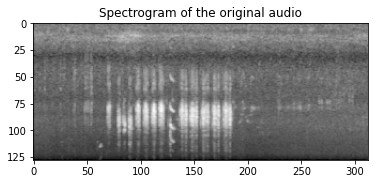

In [14]:
plt.imshow(spec_img[0], cmap='gray')
plt.title('Spectrogram of the original audio')
plt.show()

In [22]:
def img_to_audio(img, mean, std, spec_min, spec_max, sr, eps=1e-14):
    img_norm = img * (spec_max - spec_min) / 255 + spec_min
    spec_db = img_norm * std + mean
    spec = librosa.db_to_power(spec_db)
    res = librosa.feature.inverse.mel_to_audio(spec, sr=sr, hop_length=512)
    return res

## FGSM

This algorithm attempts a single step in the direction of the ascending gradient

In [15]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True, dtype=torch.float32)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [18]:
X = torch.tensor(spec_img).unsqueeze(0).float()
y = torch.tensor([0])
delta = fgsm(model, X, y, 0.1)
yp = model(X + delta)
y_prev = model(X)

print(f'Prediction before an attack: {torch.softmax(y_prev, 1)}')
print(f'Prediction after an attack: {torch.softmax(yp, 1)}')

Prediction before an attack: tensor([[0.9326, 0.0674]], grad_fn=<SoftmaxBackward>)
Prediction after an attack: tensor([[0.5959, 0.4041]], grad_fn=<SoftmaxBackward>)


As we can see, the prediction after an attack is not perfectly changing the predicted class of the attacked audio, but still has some tendency of giving more obscure prediction, as the probabilities for both classes are now roughly the same

In [19]:
# save the example for the future testing
fgsm_example = X + delta

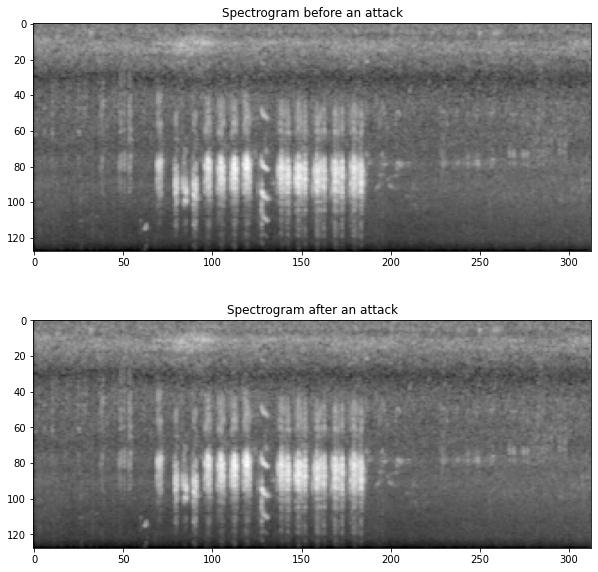

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(X.numpy()[0][0], cmap='gray')
plt.title('Spectrogram before an attack')
plt.subplot(212)
plt.imshow((X+delta).numpy()[0][0], cmap='gray')
plt.title('Spectrogram after an attack')
plt.show()

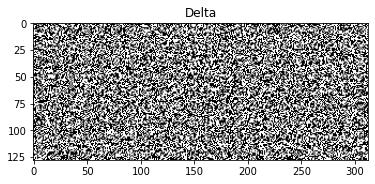

In [21]:
plt.imshow(delta.numpy()[0][0], cmap='gray')
plt.title('Delta')
plt.show()

In [23]:
audio = img_to_audio((X + delta).numpy()[0][0], mean, std, spec_min, spec_max, sr)
wavfile.write('fgsm.wav', sr, audio)
IPython.display.Audio("fgsm.wav")

I am not the ornitology expert, but the audio seems to be very similar to the original bird sound

## PGD

It is an iterative FGSM, the continuous movement into the gradient ascent direction

In [24]:
def pgd(model, X, y, epsilon=0.1, alpha=1e3, num_iter=500):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0] * alpha * delta.grad.data).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

In [25]:
X = torch.tensor(spec_img).unsqueeze(0).float()
y = torch.tensor([0])
delta = pgd(model, X, y, 0.1, 1e3, 500)
yp = model(X + delta)
y_prev = model(X)

print(f'Prediction before an attack: {torch.softmax(y_prev, 1)}')
print(f'Prediction after an attack: {torch.softmax(yp, 1)}')

Prediction before an attack: tensor([[0.9326, 0.0674]], grad_fn=<SoftmaxBackward>)
Prediction after an attack: tensor([[0.4469, 0.5531]], grad_fn=<SoftmaxBackward>)


In [26]:
pgd_example = X + delta

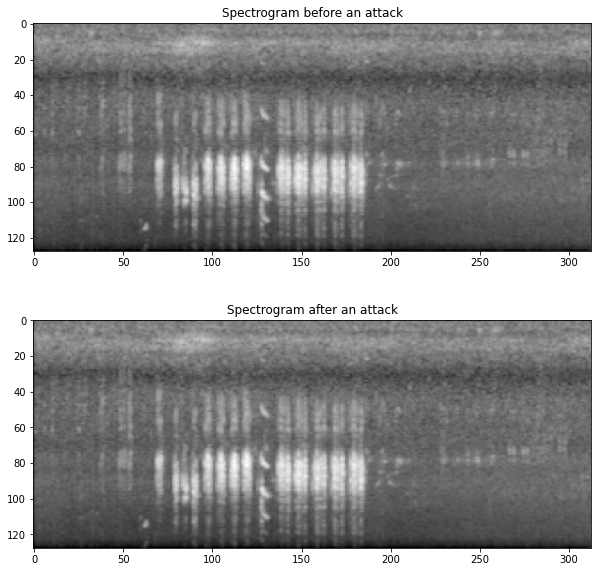

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(X.numpy()[0][0], cmap='gray')
plt.title('Spectrogram before an attack')
plt.subplot(212)
plt.imshow((X+delta).numpy()[0][0], cmap='gray')
plt.title('Spectrogram after an attack')
plt.show()

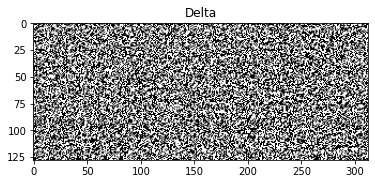

In [28]:
plt.imshow(delta.numpy()[0][0], cmap='gray')
plt.title('Delta')
plt.show()

In [29]:
audio = img_to_audio((X + delta).numpy()[0][0], mean, std, spec_min, spec_max, sr)
wavfile.write('pgd.wav', sr, audio)
IPython.display.Audio("pgd.wav")

In this audio sample one could also notice that there are no major differences from the original one

## CW attack

It is a distance-minimaztion attack, thus, let us choose L2-distance for the sake of convenience

Here we can see an interesting example of my complete inability of making a successful CW attack

At first, I was trying to implement it myself, then I became frustrated and tried the approach suggested by https://github.com/Harry24k/CW-pytorch/blob/master/CW.ipynb , but it still does not work. I did not succeed in identifying the mistake, so I would be thankful for any feedback on that!

In [30]:
def cw_l2_attack(model, X, y, c=20, kappa=0, max_iter=1000, learning_rate=1):
    def f(x) :
        outputs = model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        return loss
    
    w = torch.zeros_like(X, requires_grad=True)
    optimizer = optim.Adam([w], lr=learning_rate)
    prev = 1e10
    for step in range(max_iter):
        a = 1/2 * (torch.tanh(w) + 1)
        loss1 = nn.MSELoss(reduction='sum')(a, X)
        loss2 = c * f(a)
        cost = loss1 - loss2
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if step % (max_iter // 10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost

    attack_images = 1/2 * (torch.tanh(w) + 1)

    return attack_images

In [31]:
X = torch.tensor(spec_img).unsqueeze(0).float()
y = torch.tensor([0])
delta = cw_l2_attack(model, X, y).detach()
yp = model(X + delta)
y_prev = model(X)

print(f'Prediction before an attack: {torch.softmax(y_prev, 1)}')
print(f'Prediction after an attack: {torch.softmax(yp, 1)}')

Prediction before an attack: tensor([[0.9326, 0.0674]], grad_fn=<SoftmaxBackward>)
Prediction after an attack: tensor([[0.9301, 0.0699]], grad_fn=<SoftmaxBackward>)


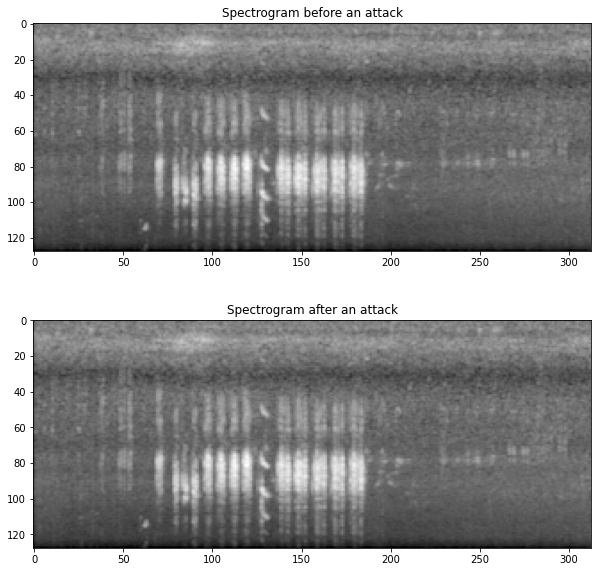

In [32]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(X.numpy()[0][0], cmap='gray')
plt.title('Spectrogram before an attack')
plt.subplot(212)
plt.imshow((X+delta).numpy()[0][0], cmap='gray')
plt.title('Spectrogram after an attack')
plt.show()

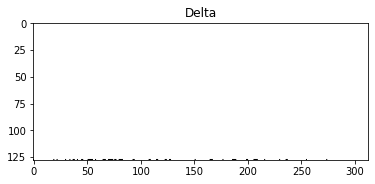

In [33]:
plt.imshow(delta.numpy()[0][0], cmap='gray')
plt.title('Delta')
plt.show()

# Adversarial training

In [34]:
def train_epoch(model, loss_fn, loader, optimizer=None, lr_scheduler=None):
    batch_losses=[]
    err = 0
    for data in tqdm(loader):
        x, y = data
        x = x.type(torch.float32)
        if optimizer:
            optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        batch_losses.append(loss.item())
        if optimizer:
            loss.backward()
            optimizer.step()
        err += (y_hat.max(dim=1)[1] != y).sum().item()
    if lr_scheduler:
        lr_scheduler.step()
    return err / len(loader.dataset), np.mean(batch_losses)

def train_epoch_adversarial(model, loss_fn, loader, attack, optimizer=None, lr_scheduler=None):
    batch_losses = []
    err = 0
    for data in tqdm(loader):
        x, y = data
        x = x.type(torch.float32)
        if optimizer:
            optimizer.zero_grad()
        delta = attack(model, x, y)
        yp = model(x + delta)
        loss = loss_fn(yp, y)
        batch_losses.append(loss.item())
        if optimizer:
            loss.backward()
            optimizer.step()
        err += (yp.max(dim=1)[1] != y).sum().item()
    if lr_scheduler:
        lr_scheduler.step()
    return err / len(loader.dataset), np.mean(batch_losses)

## Evaluation of the non-robust model

In [35]:
model_not_robust = BirdClassificationModel()
optimizer = optim.Adam(model_not_robust.parameters(), lr=1e-5)
epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [36]:
for epoch in range(epochs):
    model_not_robust.train()
    train_err, train_loss = train_epoch(model_not_robust, loss_fn, train_dataloader, optimizer)
    model_not_robust.eval()
    test_err, test_loss = train_epoch(model_not_robust, loss_fn, test_dataloader)
    adv_err, adv_loss = train_epoch_adversarial(model_not_robust, loss_fn, test_dataloader, fgsm)
    print(f'Epoch {epoch}')
    print(f'\tTrain err {train_err}\tTrain loss {train_loss}')
    print(f'\tTest err {test_err}\tTest loss {test_loss}')
    print(f'\tAdversarial err {adv_err}\tAdversarial loss {adv_loss}')
    print('')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 0
	Train err 0.4166666666666667	Train loss 0.693303628762563
	Test err 0.4807692307692308	Test loss 0.7951382795492044
	Adversarial err 0.625	Adversarial loss 1.3309049571935947



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1
	Train err 0.08333333333333333	Train loss 0.31810091038544974
	Test err 0.22115384615384615	Test loss 0.5237958012148738
	Adversarial err 0.7019230769230769	Adversarial loss 1.124370534832661



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2
	Train err 0.0125	Train loss 0.19283674309651058
	Test err 0.18269230769230768	Test loss 0.4358887992297801
	Adversarial err 0.6730769230769231	Adversarial loss 1.0691195105990539



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3
	Train err 0.0	Train loss 0.1261492391427358
	Test err 0.15384615384615385	Test loss 0.3987972033210099
	Adversarial err 0.625	Adversarial loss 1.0598339260770724



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4
	Train err 0.0	Train loss 0.08721750800808271
	Test err 0.14423076923076922	Test loss 0.3761257892653633
	Adversarial err 0.5961538461538461	Adversarial loss 1.0597195219821656



As one can see, the adversarial error remains quite the same during the whole training process, while regular train and test errors tend to converge to 0

In [37]:
torch.save(model_not_robust.state_dict(), "model_not_robust.pt")

## An attempt to train a robust model

In [38]:
model_robust = BirdClassificationModel()
optimizer = optim.Adam(model_robust.parameters(), lr=1e-5)
epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [39]:
for epoch in range(epochs):
    model_robust.train()
    adv_err, adv_loss = train_epoch_adversarial(model_robust, loss_fn, train_dataloader, fgsm, optimizer)
    model_robust.eval()
    test_err, test_loss = train_epoch(model_robust, loss_fn, test_dataloader)
    
    print(f'Epoch {epoch}')
    print(f'\tAdversarial err {adv_err}\tAdversarial loss {adv_loss}')
    print(f'\tTest err {test_err}\tTest loss {test_loss}')
    print('')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 0
	Adversarial err 0.8708333333333333	Adversarial loss 1.3746227900187173
	Test err 0.2980769230769231	Test loss 0.5642304080896653



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1
	Adversarial err 0.49166666666666664	Adversarial loss 0.7293743332227071
	Test err 0.23076923076923078	Test loss 0.49951694389948476



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2
	Adversarial err 0.24583333333333332	Adversarial loss 0.4997746586799622
	Test err 0.19230769230769232	Test loss 0.4613984151958273



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3
	Adversarial err 0.08333333333333333	Adversarial loss 0.36026400129000347
	Test err 0.20192307692307693	Test loss 0.4389351630905786



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4
	Adversarial err 0.029166666666666667	Adversarial loss 0.26676955819129944
	Test err 0.21153846153846154	Test loss 0.42413697465179634



Here both adversarial and test errors are converging to zero (however, test error converges a bit slower than in the regular training process

In [40]:
torch.save(model_robust.state_dict(), "model_robust.pt")